# Loading Data

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_colwidth', None)

In [25]:
authors = pd.read_sql(f"""
    select count(*) as total_authors
    FROM
    (
        SELECT distinct author_id
        FROM reviews
    )
""", sqlite3.connect("initial_data/database.sqlite"))
total_authors = authors['total_authors'][0]
print(f"Total number of unique users {total_authors}")

Total number of unique users 1438939


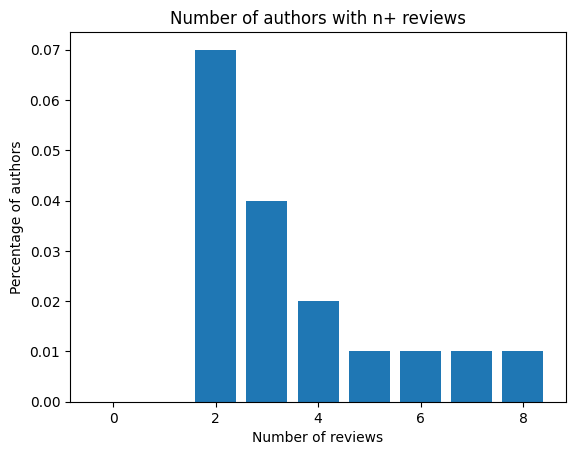

In [26]:
n_plus_reviews = {0:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0}
for number in n_plus_reviews.keys():
    categories = pd.read_sql(f"""
        SELECT count(*) AS number_of_authors
        FROM 
            (
                SELECT COUNT(*) 
                FROM reviews
                GROUP BY (author_id)
                HAVING COUNT(*) > {number}
            )
    """, sqlite3.connect("initial_data/database.sqlite"))

    if number != 0:
        n_plus_reviews[number] = round(categories['number_of_authors'][0] / total_authors, 2)


# Plotting the results
plt.bar(n_plus_reviews.keys(), n_plus_reviews.values())
plt.xlabel('Number of reviews')
plt.ylabel('Percentage of authors')
plt.title('Number of authors with n+ reviews')
plt.show()



Number of authors with at least 1 positive reviews 1338250


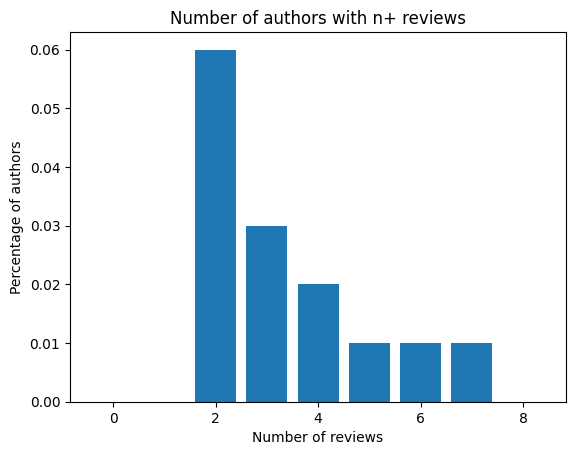

In [27]:
n_plus_positive_reviews = {0:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0}
for number in n_plus_positive_reviews.keys():
    categories = pd.read_sql(f"""
        SELECT count(*) AS number_of_authors
        FROM 
            (
                SELECT COUNT(*) 
                FROM reviews
                WHERE rating > 3
                GROUP BY (author_id)
                HAVING COUNT(*) > {number}
            )
    """, sqlite3.connect("initial_data/database.sqlite"))
    if number != 0:
        n_plus_positive_reviews[number] = round(categories['number_of_authors'][0] / total_authors,2)
    else:
        print(f"Number of authors with at least 1 positive reviews {categories['number_of_authors'][0]}")


# Plotting the results
plt.bar(n_plus_positive_reviews.keys(), n_plus_positive_reviews.values())
plt.xlabel('Number of reviews')
plt.ylabel('Percentage of authors')
plt.title('Number of authors with n+ reviews')
plt.show()



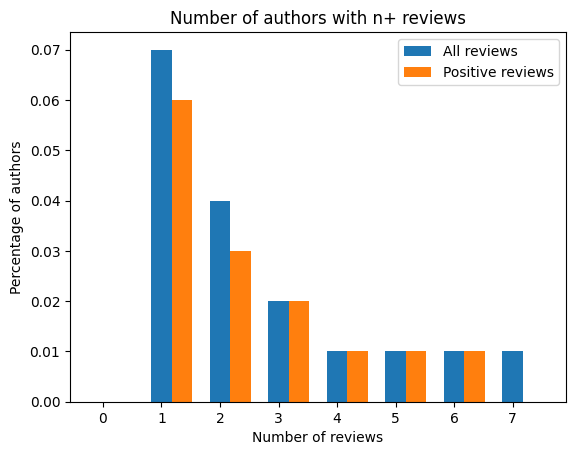

In [28]:
#plot the results in one graph
import numpy as np

n = np.arange(len(n_plus_reviews.keys()))
width = 0.35
plt.bar(n, n_plus_reviews.values(), label='All reviews',width = width)
plt.bar(n+width, n_plus_positive_reviews.values(), label='Positive reviews', width = width)
plt.xlabel('Number of reviews')
plt.ylabel('Percentage of authors')
plt.title('Number of authors with n+ reviews')
plt.legend()
plt.show()

In [ ]:
# Get the K most recent reviews for each user
K = 5

reviews = pd.read_sql(f"""
    SELECT author_id, podcast_id ,rating, created_at
    FROM reviews
    WHERE author_id IN
    (
        SELECT author_id
        FROM reviews
        WHERE rating > 3
        GROUP BY (author_id)
        HAVING COUNT(*) > {K-1}
    )
    ORDER BY created_at DESC
    LIMIT {5}
""", sqlite3.connect("initial_data/database.sqlite"))

print(reviews)




In [ ]:
# join reviews with podcasts on podcast_id
podcast_w_category = pd.read_sql(f"""
    SELECT podcast_id, title, category
    FROM categories JOIN podcasts USING (podcast_id)
""", sqlite3.connect("initial_data/database.sqlite"))

podcast_w_reviews = pd.read_sql(f"""
    SELECT podcasts.podcast_id, podcasts.title, reviews.title as rev_title, reviews.content, reviews.rating, reviews.author_id, reviews.created_at 
    FROM reviews JOIN podcasts USING (podcast_id)
""", sqlite3.connect("initial_data/database.sqlite"))

print(podcast_w_reviews)


In [44]:
# Join the two dataframes
rev_w_pod_w_cat = pd.merge(podcast_w_reviews, podcast_w_category, on='podcast_id', how='inner')

Size of the dataframe (4388778, 9)


In [ ]:
# # add podcast category to the reviews dataframe
# all_data = pd.read_sql(f"""
#     SELECT * 
#     FROM (reviews join podcasts USING (podcast_id)) join categories USING (podcast_id)
# """, sqlite3.connect("initial_data/database.sqlite"))
# print(f"Size of the dataframe {reviews.shape}")
# reviews = pd.merge(reviews, podcast_w_category, on='podcast_id', how='inner')
# print(f"Size of the dataframe {reviews.shape}")

# add podcast category to the reviews dataframe
all_data = pd.read_sql(f"""
    SELECT * 
    FROM (reviews join podcasts USING (podcast_id)) join categories USING (podcast_id)
""", sqlite3.connect("initial_data/database.sqlite"))
print(f"Size of the dataframe {reviews.shape}")
reviews = pd.merge(reviews, podcast_w_category, on='podcast_id', how='inner')
print(f"Size of the dataframe {reviews.shape}")

In [ ]:
# add podcast category to the reviews dataframe
all_data = pd.read_sql(f"""
    SELECT * 
    FROM (reviews join podcasts USING (podcast_id)) join categories USING (podcast_id)
""", sqlite3.connect("initial_data/database.sqlite"))

In [6]:
print(f"Size of the dataframe {all_data.shape}")

Size of the dataframe (4388778, 11)


In [7]:
# for each user get the K most recent reviews from all_data
all_data = all_data.sort_values(by=['author_id', 'created_at'], ascending=False)


In [ ]:
# remove columns slug, itunes_id
all_data = all_data.drop(columns=['slug', 'itunes_id', 'itunes_url'])

# print columns
print(all_data.columns)

In [10]:
# change column names
all_data.columns = ['podcast_id', 'review_title', 'review_content', 'rating', 'author_id', 'created_at', 'podcast_title', 'category']


In [ ]:
print (all_data.head())

In [3]:
# get users with more than K reviews from db
K = 4
reviews = pd.read_sql(f"""
    SELECT podcast_id, title as review_title, content as review_content, rating, author_id, created_at
    FROM reviews
    WHERE author_id IN
    (
        SELECT author_id
        FROM reviews
        WHERE rating > 3
        GROUP BY (author_id)
        HAVING COUNT(*) > {K}
    )
""", sqlite3.connect("initial_data/database.sqlite"))

# get podcasts with categories from db
podcast_w_category = pd.read_sql(f"""
    SELECT podcast_id, title as podcast_title, category
    FROM categories JOIN podcasts USING (podcast_id)
""", sqlite3.connect("initial_data/database.sqlite"))

# join reviews with podcasts on podcast_id
rev_w_pod_w_cat = pd.merge(reviews, podcast_w_category, on='podcast_id', how='inner')


In [4]:
# sort by author_id and created_at
rev_w_pod_w_cat = rev_w_pod_w_cat.sort_values(by=['author_id', 'created_at'], ascending=False)

In [5]:
# get shape of the dataframe
print(f"Size of dataframe with users with 5 or more reviews {rev_w_pod_w_cat.shape}")

Size of the dataframe (498692, 8)


In [28]:
# keep the first K reviews for each user
rev_w_pod_w_cat_only_5 = rev_w_pod_w_cat.groupby('author_id').head(K+1)
print(f"Size of dataframe with users with exactly 5 reviews (sorted by creation data): {rev_w_pod_w_cat_only_5.shape[0]}")

# get unique users
print(f"Unique users: {rev_w_pod_w_cat_only_5['author_id'].unique().shape[0]}")

Size of dataframe with users with exactly 5 reviews (sorted by creation data): 116740
Unique users: 23351


In [29]:
# count number of reviews for each user
print(rev_w_pod_w_cat_only_5.groupby('author_id').count().max())

podcast_id        5
review_title      5
review_content    5
rating            5
created_at        5
podcast_title     5
category          5
dtype: int64


In [30]:
# create dataframe with only necessary columns
datapoints = rev_w_pod_w_cat_only_5[['author_id', 'category', 'created_at']]

In [41]:
# get unique users
users = datapoints['author_id'].unique()

# Idea 1 
# Each user is a datapoint with 109 features (categories) 0-1
# populate the matrix 
matrix_all_categories = pd.DataFrame(index=users, columns=datapoints['category'].unique())
# fill the matrix with zeros
matrix_all_categories = matrix_all_categories.fillna(0)
# If user reviewd in datapoints, set the value to 1
for index, row in datapoints.iterrows():
    matrix_all_categories.loc[row['author_id'], row['category']] = 1


In [ ]:
# Idea 2
# Each user is a datapoint with K+1 features (categories) type of category
# This one should be working fine also with name of podcast instead of category
# However, is will be very sparse
matrix_5_categories = pd.DataFrame(index=users, columns=['category_1', 'category_2', 'category_3', 'category_4', 'category_5'])
# fill the matrix with zeros
matrix_5_categories = matrix_5_categories.fillna(0)
# If user reviewd in datapoints, set the value to 1
i = 1
for index, row in datapoints.iterrows():
    matrix_5_categories.loc[row['author_id'], matrix_5_categories.columns[i-1]] = row['category']
    i += 1
    if i > 5:i = 1

print(matrix_5_categories.head())

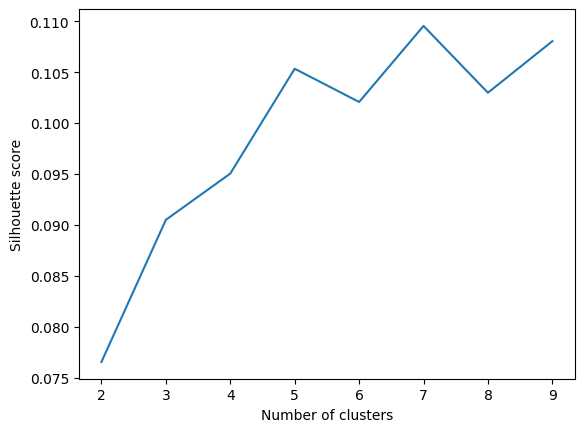

In [42]:
# Clustering of matrix_all_categories
matrix_all_categories = matrix_all_categories.astype('int')
# import the necessary packages
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np

# create a list of K values
K = range(2, 10)

# create a list of silhouette scores
silhouette_scores = []

# loop over K values
for k in K:
    # create a KMeans instance with k clusters
    kmeans = KMeans(n_clusters=k)
    # fit the model to the matrix
    kmeans.fit(matrix_all_categories)
    # get the silhouette score
    score = silhouette_score(matrix_all_categories, kmeans.labels_)
    # append the score to the list
    silhouette_scores.append(score)

# plot the results
plt.plot(K, silhouette_scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/3, moves: 79, cost: 4255.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/3, moves: 10, cost: 4329.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/3, moves: 118, cost: 4253.0
Run 3, iteration: 2/3, moves: 14, cost: 4253.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/3, moves: 56, cost: 4321.0
Run 4, iteration: 2/3, moves: 37, cost: 4321.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/3, moves: 71, cost: 4290.0
Best run was number 3
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/3, moves: 70, cost: 4153.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/3, moves: 133, cost: 

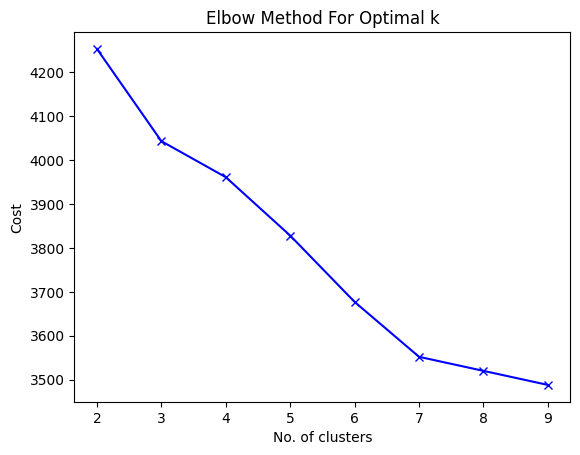

In [51]:
# Categorical data clustering
# Import the necessary packages

# Check source: https://www.analyticsvidhya.com/blog/2021/06/kmodes-clustering-algorithm-for-categorical-data/
# Check source: https://medium.com/geekculture/the-k-modes-as-clustering-algorithm-for-categorical-data-type-bcde8f95efd7
matrix_5_categories = matrix_5_categories.astype('str')
from kmodes.kmodes import KModes
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np

# create a list of K values
K = range(2, 10)

# create a list of silhouette scores
cost = []

# loop over K values
for k in K:
    # create a KMeans instance with k clusters
    kmodes = KModes(n_clusters=k, init = "random", n_init = 5, verbose=1 ,max_iter=3 )
    # fit the model to the matrix
    kmodes.fit(matrix_5_categories)
    # get the silhouette score
    cost.append(kmodes.cost_)

# plot the results
plt.plot(K, cost, 'bx-')
plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.show()
